# **TEXT SUMMARIZATION :**
# **Amazon Reviews Summarization using BART model**  
Created on : 13th Oct 2025

---



---



# **Load BART Model**

**Releasing hugging face and GPU cache**

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!rm -rf ~/.cache/huggingface
!rm -rf ~/.cache/torch

**Loading BART model and tokenizer : bart-large , from transformers library**

In [1]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [2]:
model=BartForConditionalGeneration.from_pretrained("facebook/bart-large",device_map=None).to("cpu")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [3]:
print(type(model))

<class 'transformers.models.bart.modeling_bart.BartForConditionalGeneration'>


In [4]:
tokenizer=BartTokenizer.from_pretrained("facebook/bart-large")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

# **Load Dataset**

**Loading Amazon Reviews Dataset, using datasets library**

In [5]:
from datasets import load_dataset,Dataset

In [6]:
dataset = load_dataset("csv", data_files="file1.csv")["train"]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
def remove_nulls(example):
    return example["Text"] is not None and example["Summary"] is not None

dataset = dataset.filter(remove_nulls)

# Remove duplicates
df = dataset.to_pandas()

# Drop duplicates and NaN
df = df.drop_duplicates(subset=["Text", "Summary"])
df = df.dropna(subset=["Text", "Summary"])

dataset = Dataset.from_pandas(df)

Filter:   0%|          | 0/170536 [00:00<?, ? examples/s]

In [8]:
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(20000))

In [9]:
print(dataset)

Dataset({
    features: ['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', '__index_level_0__'],
    num_rows: 20000
})


In [10]:
data=dataset.remove_columns(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', '__index_level_0__'])

In [11]:
print(data)

Dataset({
    features: ['Summary', 'Text'],
    num_rows: 20000
})


In [12]:
split_data=data.train_test_split(test_size=0.3)
eval_split=split_data['test'].train_test_split(test_size=0.5)

train_df=split_data['train']
test_df=eval_split['test']
eval_df=eval_split['train']

In [13]:
print(train_df)

Dataset({
    features: ['Summary', 'Text'],
    num_rows: 14000
})


In [14]:
print(test_df)

Dataset({
    features: ['Summary', 'Text'],
    num_rows: 3000
})


In [15]:
print(eval_df)

Dataset({
    features: ['Summary', 'Text'],
    num_rows: 3000
})


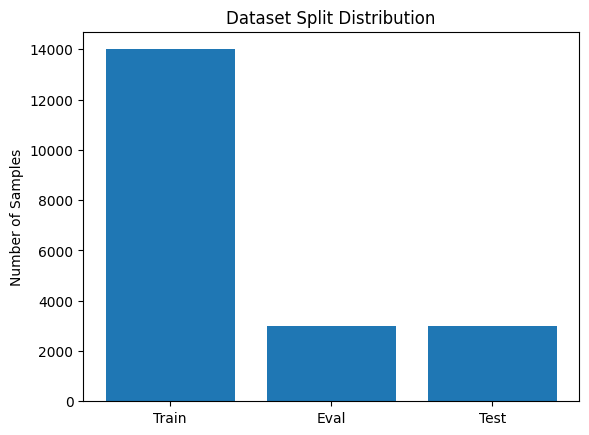

In [16]:
import matplotlib.pyplot as plt

# Dataset split sizes
sizes = [len(train_df), len(eval_df), len(test_df)]
labels = ['Train', 'Eval', 'Test']
plt.bar(labels, sizes)
plt.title("Dataset Split Distribution")
plt.ylabel("Number of Samples")
plt.show()

# **Tokenizing Model Inputs**

**Tokenizing  train_df,  eval_df  to load into model**

In [17]:
def preprocess_function(examples):
    # Convert 'Text' and 'Summary' to strings to handle potential non-string values
    texts = [str(text) for text in examples["Text"]]
    summaries = [str(summary) for summary in examples["Summary"]]

    model_inputs = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )
    labels = tokenizer(
        summaries,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = train_df.map(preprocess_function, batched=True)

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

In [18]:
tokenized_eval=eval_df.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [19]:
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)
tokenized_eval.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

In [20]:
print(type(tokenized_datasets))
print(type(tokenized_eval))

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


# **Training the model**

In [21]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [22]:
from transformers import Trainer, TrainingArguments

In [23]:
trainer = Trainer(
    model=model,
    args=TrainingArguments(
      output_dir="./results",
      per_device_train_batch_size=8,
      gradient_accumulation_steps=2,
      fp16=True,
      dataloader_num_workers=2,
      save_steps=1000,
      save_total_limit=2,
      report_to="none",
      num_train_epochs=3,
      logging_steps=200,
    ),
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_eval
)

In [24]:
import torch
torch.cuda.is_available()

True

In [25]:
trainer.train()

Step,Training Loss
200,2.923300
400,0.214800
600,0.186300
800,0.179000
1000,0.158100
1200,0.151500
1400,0.151100
1600,0.144900
1800,0.136900
2000,0.124500


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2625, training_loss=0.3620195445106143, metrics={'train_runtime': 3212.469, 'train_samples_per_second': 13.074, 'train_steps_per_second': 0.817, 'total_flos': 4.5509196644352e+16, 'train_loss': 0.3620195445106143, 'epoch': 3.0})

*If training needs to started again  
First remove **results** folder : **!rm -rf ./results**  
Also clear GPU and hugging face cache*

In [ ]:
#!rm -rf ./results

**Evaluating Trained Model on eval_df and test_df**

In [26]:
metrics=trainer.evaluate()
print(metrics)

{'eval_loss': 0.16944342851638794, 'eval_runtime': 55.9722, 'eval_samples_per_second': 53.598, 'eval_steps_per_second': 6.7, 'epoch': 3.0}


In [27]:
tokenized_test = test_df.map(preprocess_function, batched=True)
metrics=trainer.evaluate(tokenized_test)
print(metrics)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'eval_loss': 0.17071956396102905, 'eval_runtime': 55.6339, 'eval_samples_per_second': 53.924, 'eval_steps_per_second': 6.74, 'epoch': 3.0}


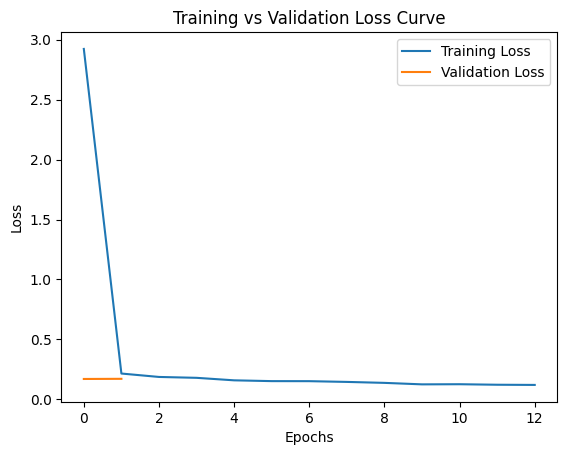

In [28]:
import matplotlib.pyplot as plt

train_losses = trainer.state.log_history
train_loss = [x['loss'] for x in train_losses if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_losses if 'eval_loss' in x]

plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [29]:
len(train_loss), len(eval_loss)

(13, 2)

**Saving the trained Model in Drive**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
save_path = "/content/drive/MyDrive/V10_final_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/V10_final_model/tokenizer_config.json',
 '/content/drive/MyDrive/V10_final_model/special_tokens_map.json',
 '/content/drive/MyDrive/V10_final_model/vocab.json',
 '/content/drive/MyDrive/V10_final_model/merges.txt',
 '/content/drive/MyDrive/V10_final_model/added_tokens.json')

In [52]:
import json
with open("/content/drive/MyDrive/V10_final_model/training_metrics.json", "w") as f:
    json.dump(trainer.state.log_history, f)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

# **Model Testing using Evaluation Metrics**

**Load Model from Drive**

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!rm -rf ~/.cache/huggingface
!rm -rf ~/.cache/torch

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model=BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/V10_final_model")

In [ ]:
tokenizer=BartTokenizer.from_pretrained("/content/drive/MyDrive/V10_final_model")

**Load Testing Dataset**

In [32]:
from datasets import load_dataset,Dataset

In [33]:
dataset = load_dataset("csv", data_files="file1.csv")["train"]

In [34]:
def remove_nulls(example):
    return example["Text"] is not None and example["Summary"] is not None

dataset = dataset.filter(remove_nulls)

# Remove duplicates
df = dataset.to_pandas()

# Drop duplicates and NaN
df = df.drop_duplicates(subset=["Text", "Summary"])
df = df.dropna(subset=["Text", "Summary"])

dataset = Dataset.from_pandas(df)

In [37]:
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(200))

**Tokenizing Inputs for Testing**

In [38]:
texts = [t[0] if isinstance(t, list) else t for t in dataset["Text"]]

In [39]:
inputs = tokenizer(
    texts,
    truncation=True,
    padding=True,
    return_tensors="pt"
)

**Generating Summaries for Testing in Batches**

In [40]:
from tqdm import tqdm
import torch

preds = []
batch_size = 8

# Make sure model is on GPU
model.to("cuda")
model.eval()

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

for i in tqdm(range(0, len(input_ids), batch_size), desc="Generating summaries"):
    batch_input_ids = input_ids[i:i+batch_size].to("cuda")
    batch_attention_mask = attention_mask[i:i+batch_size].to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

    preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))

torch.cuda.empty_cache()

Generating summaries: 100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


In [41]:
print(len(preds))

200


**Calculating Bert_Score and Rouge_Score**

In [43]:
pip install evaluate

In [44]:
pip install rouge_score

In [46]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00


In [47]:
from evaluate import load

# References
refs = dataset["Summary"]

rouge = load("rouge")
bertscore = load("bertscore")
bertscore_results = bertscore.compute(predictions=preds, references=refs, lang="en")
rouge_results = rouge.compute(predictions=preds, references=refs)
print("ROUGE:", rouge_results)


import numpy as np


print(f"Average BERTScore Precision: {np.mean(bertscore_results['precision']):.4f}")
print(f"Average BERTScore Recall:    {np.mean(bertscore_results['recall']):.4f}")
print(f"Average BERTScore F1:        {np.mean(bertscore_results['f1']):.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': np.float64(0.2107297424797424), 'rouge2': np.float64(0.09278267565767567), 'rougeL': np.float64(0.20556435231435224), 'rougeLsum': np.float64(0.20595625901875897)}
Average BERTScore Precision: 0.8671
Average BERTScore Recall:    0.8569
Average BERTScore F1:        0.8615


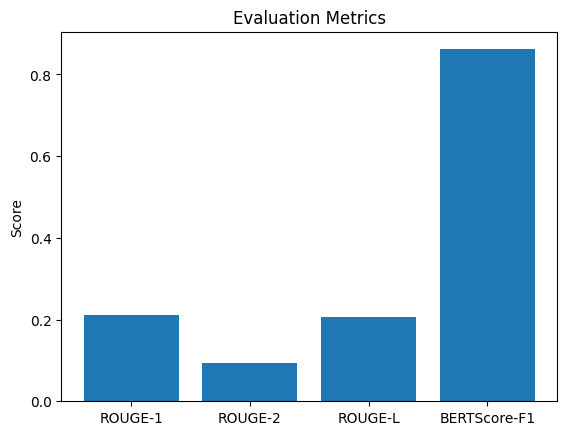

In [48]:
metrics = {
    "ROUGE-1": rouge_results["rouge1"],
    "ROUGE-2": rouge_results["rouge2"],
    "ROUGE-L": rouge_results["rougeL"],
    "BERTScore-F1": sum(bertscore_results["f1"]) / len(bertscore_results["f1"])
}

plt.bar(metrics.keys(), metrics.values())
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.show()

In [ ]:
# Consistency of Model

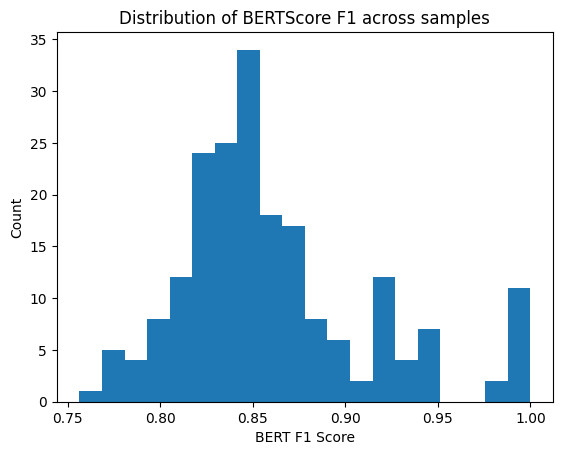

In [49]:
plt.hist(bertscore_results["f1"], bins=20)
plt.title("Distribution of BERTScore F1 across samples")
plt.xlabel("BERT F1 Score")
plt.ylabel("Count")
plt.show()